# Using NumPy and SciPy modules

In addition to using Cantera and Pint to help solve thermodynamics problems, we will need to use some additional packages in the scientific Python ecosystem to make plots, solve systems of equations, integrate ordinary differential equations, and more.

The [*SciPy Lecture Notes*](https://scipy-lectures.org) are excellent, detailed resources on all these topics, and Python programming in general.

The examples contained in this electronic book will integrate these techniques as needed, but this notebook contains some specific examples.

## Index

1. [Plotting](#Plotting)
2. [Solving systems of equations](#Solving-systems-of-equations)
3. [Integrating ODE systems](#Integrating-ODE-systems)
4. [Optimization](#Optimization)

## Plotting

We can use [Matplotlib](https://matplotlib.org) to produce nice plots of our results. If you used Anaconda to set up your computing environment, you likely already have Matplotlib installed; if not, see their [installation instructions](https://matplotlib.org/users/installing.html).

Matplotlib provides an interface that is very similar to what you might already know from Matlab: `pyplot`. You can import this in Python files or a Jupyter notebook with the standard abbreviation `plt`:

In [4]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
# these lines are only for helping improve the display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 150

For example, let's generate some values of an independent variable $x$ linearly spaced between 0 and 10 (using the NumPy function [`linspace()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)), and then plot the function $y(x) = \sin(x)$. We can also add labels to the axes, a legend, and a helpful grid.

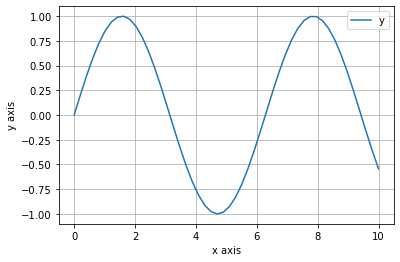

In [7]:
import numpy as np

x = np.linspace(0, 10, num=50, endpoint=True)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend('y(x)')
plt.grid(True)
plt.show()

We can also plot multiple data series in a single figure:

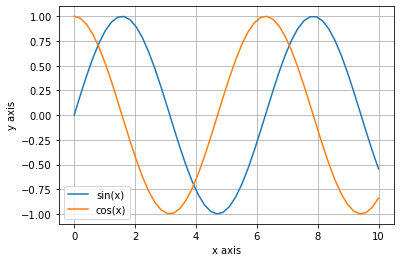

In [8]:

plt.plot(x, y, label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.grid(True)
plt.legend()
plt.show()

Or, we can use subplots to plot multiple axes in the same overall figure:

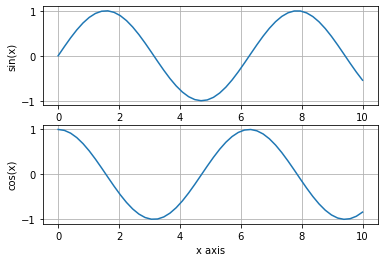

In [11]:
# 2 rows, 1 column
fig, axes = plt.subplots(2, 1)

axes[0].plot(x, y, label='sin(x)')
axes[0].set_ylabel('sin(x)')
axes[0].grid(True)

axes[1].plot(x, np.cos(x), label='cos(x)')
axes[1].set_xlabel('x axis')
axes[1].set_ylabel('cos(x)')
axes[1].grid(True)

plt.show()

## Solving systems of equations

Frequently we will encounter a system of one or more equations that involves an equal number of unknowns. If this is a linear system of equations, we can use linear algebra and the NumPy [`linalg.solve()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) function, but more often in thermodynamics we encounter complex and/or nonlinear systems.

In cases like this, we will need to set up our problems to find the roots, or zeroes, of the function(s); in other words, given a function $f(x)$, finding the root means to find the value of $x$ such that $f(x) = 0$. If we are dealing with a system of equations and the same number of unknowns, then these would be vectors: $\mathbf{f}(\mathbf{x}) = 0$.

(You might be wondering what to do about equations that don't equal zero... for example, if you have something like $f(x) = g(x)$. In this case, you just need to manipulate the equation to be in the form $f(x) - g(x) = 0$.)

The [SciPy optimization module](https://docs.scipy.org/doc/scipy/reference/optimize.html) provides functions to find roots of equations; for scalar equations, we can use [`root_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar), and for vector equations, we can use [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html).

### Scalar equations 

Let's first look at an example of a scalar function: one equation, one unknown.

Find the root of this equation:
\begin{equation}
\cos(x) = x^3
\end{equation}

We need to create a Python function that returns $f(x) = 0$, so that the function returns zero when the input value of $x$ is the (correct) root. Then, we can use the `root_scalar` function with some initial guesses.

In [27]:
import numpy as np
from scipy import optimize

def func(x):
    return np.cos(x) - x**3

sol = optimize.root_scalar(func, x0=1.0, x1=2.0)

print(f'Root: x ={sol.root: .3f}')

print(f'Function evaluated at root: {func(sol.root)}')

Root: x = 0.865
Function evaluated at root: -2.220446049250313e-16


### Systems of equations / vector functions

We can also solve systems of equations in a similar fashion using the SciPy [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) functino, where we find the roots $\mathbf{x}$ that satisfy $\mathbf{f} (\mathbf{x}) = 0$.

For example, let's try to find the values of $x$ and $y$ that satisfy these equations:
\begin{align}
x \ln (x) &= y^3 \\
\sqrt(x) &= \frac{1}{y}
\end{align}
We have two equations and two unknowns, so we should be able to find the roots.

To solve, we create a function that evaluates these equations when made equal to zero, or
\begin{align}
x \ln (x) - y^3 &= 0 \\
\sqrt(x) - \frac{1}{y} &= 0
\end{align}
then we call `root` specifying this function and two initial guesses for $x$ and $y$:

In [35]:
import numpy as np
from scipy import optimize

def system(vars):
    x = vars[0]
    y = vars[1]
    
    return [
        x*np.log(x) - y**3,
        np.sqrt(x) - (1/y)
        ]

sol = optimize.root(system, [1.0, 1.0])

x = sol.x[0]
y = sol.x[1]

print(f'Roots: x = {x: .3f}, y = {y: .3f}')

Roots: x =  1.467, y =  0.826


## Integrating ODE systems

In some cases, we encounter problems that require integrating one or more ordinary different equations in time. Depending on the form of the problem, we may need to integrate a function between two points (definite integral), or we may have a system of ordinary differential equations.

### Numerical integral of samples

In some cases we have a set of $(x,y)$ data that we want to integrate numerically.
We can do this using the NumPy [`trapz()` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html), which implements the composite trapezoidal rule.

For example, let's consider a situation where a reciprocating compressor is being used to compress ammonia vapor during a refrigeration cycle. We have some experimental measurements of the pressure-volume data during the compression stroke (see table), and we want to determine the work done on the ammonia by the piston.

| Pressure (psi) | Volume (in^3) |
|----------------|---------------|
| 65.1           | 80.0          |
| 80.5           | 67.2          |
| 93.2           | 60.1          |
| 110            | 52.5          |
| 134            | 44.8          |
| 161            | 37.6          |
| 190            | 32.5          |

To find the work done by the piston to the ammonia, we can integrate pressure with respect to volume:
\begin{equation}
W_{\text{in}} = -\int_{V_1}^{V_2} P \, dV
\end{equation}

In [46]:
import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

pressure = Q_([65.1, 80.5, 93.2, 110, 134, 161, 190], 'psi')
volume = Q_([80.0, 67.2, 60.1, 52.5, 44.8, 37.6, 32.5], 'in^3')

# convert to SI units
pressure.ito('Pa')
volume.ito('m^3')

work = -Q_(
    np.trapz(pressure.magnitude, volume.magnitude), 
    pressure.units * volume.units
    )
print(f'Work done on fluid: {work.to("J"): .2f}')

Work done on fluid: 589.45 joule


### Numerical integral of expression

We can also numerically integrate expressions/functions

### Initial value problems

In other words, we may have a system like
\begin{equation}
\frac{d \mathbf{y}}{dt} = \mathbf{f} (t, \mathbf{y})
\end{equation}
where $\mathbf{y}$ is the vector of state variables, for which we should have the initial values ($\mathbf{y}(t=0)$). In this case, we can use the SciPy function [`solve_ivp()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), part of the `integrate` module.



## Optimization